In [18]:
import time
import os
import skvideo.io
import random
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from DataSet import BatchDataset
import torch
import torch.nn  as nn
from tqdm import tqdm
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from scipy import spatial
import seaborn as sns
import shutil
import sys
import math
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
path="リサイズ"
category_key=[i for i in os.listdir(path) ]
category_id=[i for i in range(len(category_key))]
category={}
for i,j in zip(category_key,category_id):
    category[i]=j
path=[os.path.join(path,i) for i in os.listdir(path) ]
files=[os.path.join(i,j) for i in path for j in os.listdir(i)]
data=[]
for file in files:
    data.append([file,category[file.split("\\")[1]]])
        

In [3]:
image_size1,image_size2=1080//8,1920//8
#1シーンのフレーム数
T=10
#カラーチャネル3->1に変換してモデルに入力
n_channels=1

In [4]:
def transform(sample,T):
    video=sample["video"]
    label=sample["labels"]
    path=sample["paths"]
    trans_video = torch.empty(n_channels,T,image_size1,image_size2)
    trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(1),
    transforms.Resize((image_size1,image_size2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
    ])
    video = torch.Tensor(trim(video,T))
    for i in range(T):
        img = video[:,i]
        img = trans(img)
        img=img.reshape(n_channels,image_size1,image_size2)
        trans_video[:,i] = img
    sample = {'video': trans_video, 'labels': label,'paths':path}
    return sample

def trim(video,T):
    start = np.random.randint(0, video.shape[1] - (T+1))
    end = start + T
    return video[:, start:end, :, :]

In [5]:

random.seed(100)
random.shuffle(data)
n_train=int(len(data)*0.8)
n_valid=int(len(data)*0.1)
n_test=int(len(data)-n_train-n_valid)
d=[]
l=[]
for i in data:
    d.append(i[0])
    l.append(i[1])

In [6]:
train_dataset = BatchDataset(
    files=d[:n_train],
    labels=l[:n_train],
    T=T,
    transform=transform
    )
valid_dataset = BatchDataset(
    files=d[n_train:n_train+n_valid],
    labels=l[n_train:n_train+n_valid],
    T=T,
    transform=transform
    )
test_dataset = BatchDataset(
    files=d[n_train+n_valid:],
    labels=l[n_train+n_valid:],
    T=T,
    transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=48,
    shuffle=True,
    num_workers=0
    )
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
    )
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
    )

In [7]:
class VideoComp(nn.Module):
    def __init__(self, ndf=32, ngpu=1,category=2):
        super().__init__()
        self.ngpu = ngpu
        self.ndf = ndf
        self.category = category
        self.image_size = (1080//8,1920//8)
        self.n_channels = 1
        self.encoder = nn.Sequential(
            nn.Conv3d(self.n_channels, ndf, 3, 2, 1, bias=False),
            nn.BatchNorm3d(ndf),
            nn.ReLU(inplace=True),
            nn.Conv3d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.ReLU(inplace=True),
            nn.Conv3d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.ReLU(inplace=True),
            nn.Conv3d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.ReLU(inplace=True),
        )
        self.fc1=nn.Linear(34560,4000)
        self.relu=nn.ReLU(inplace=True)
        self.fc2=nn.Linear(4000,category)
        
    def forward(self,x):
        x=self.encoder(x)
        x = x.view(x.size()[0], -1)
        x=self.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [8]:
model=VideoComp(category=len(category))
model.to(device)
lr=1e-5
criterion= nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
dataloaders=dict({"train":train_loader,"valid":valid_loader,"test":test_loader})

In [9]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

In [13]:

epochs=10
scaler = torch.cuda.amp.GradScaler()

torch.backends.cudnn.benchmark=True

print(time.strftime('%Y/%m/%d %H:%M:%S'))

for epoch in range(epochs):

    for phase in["train","valid"]:
        if phase=="train":
            model.train()
        else:
            model.eval()
        
        epoch_loss = 0.0
        epoch_correct=0

        for i,batch_data in tqdm(enumerate(dataloaders[phase])):
                
            optimizer.zero_grad()   
            with torch.set_grad_enabled(phase=="train"):
                with torch.cuda.amp.autocast():
                    batch_pred=model(batch_data["video"].to(device))
                    loss = criterion(batch_pred,batch_data["labels"].to(device))
                    _, predicted = torch.max(batch_pred, 1)
                if phase=="train":
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                epoch_loss+=loss.item()*batch_data["video"].size(0)
                epoch_correct += torch.sum(predicted==batch_data["labels"].to(device))
        
        epoch_loss=epoch_loss/len(dataloaders[phase].dataset)
        epoch_acc=epoch_correct.double()/len(dataloaders[phase].dataset)
        
        if phase=="train":
            
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            test_loss.append(epoch_loss)
            test_acc.append(epoch_acc)
        print("Time {} | Epoch {}/{}|{:5}  | Loss:{:.4f} Acc:{:.4f}".format(time.strftime('%Y/%m/%d %H:%M:%S'),epoch+1,epochs,phase,epoch_loss,epoch_acc))

2022/07/30 10:37:18


116it [20:28, 10.59s/it]


Time 2022/07/30 10:57:47 | Epoch 1/10|train  | Loss:0.2233 Acc:0.9583


44it [02:36,  3.57s/it]


Time 2022/07/30 11:00:24 | Epoch 1/10|valid  | Loss:0.6932 Acc:0.8314


116it [20:48, 10.76s/it]


Time 2022/07/30 11:21:12 | Epoch 2/10|train  | Loss:0.1875 Acc:0.9674


44it [02:39,  3.62s/it]


Time 2022/07/30 11:23:51 | Epoch 2/10|valid  | Loss:0.7043 Acc:0.8184


116it [20:37, 10.67s/it]


Time 2022/07/30 11:44:28 | Epoch 3/10|train  | Loss:0.1699 Acc:0.9719


44it [02:39,  3.61s/it]


Time 2022/07/30 11:47:07 | Epoch 3/10|valid  | Loss:0.6130 Acc:0.8530


116it [20:52, 10.79s/it]


Time 2022/07/30 12:07:59 | Epoch 4/10|train  | Loss:0.1554 Acc:0.9750


44it [02:41,  3.67s/it]


Time 2022/07/30 12:10:41 | Epoch 4/10|valid  | Loss:0.6139 Acc:0.8573


116it [20:47, 10.75s/it]


Time 2022/07/30 12:31:28 | Epoch 5/10|train  | Loss:0.1446 Acc:0.9735


44it [02:38,  3.60s/it]


Time 2022/07/30 12:34:07 | Epoch 5/10|valid  | Loss:0.6122 Acc:0.8487


116it [20:34, 10.65s/it]


Time 2022/07/30 12:54:42 | Epoch 6/10|train  | Loss:0.1293 Acc:0.9757


44it [02:39,  3.62s/it]


Time 2022/07/30 12:57:21 | Epoch 6/10|valid  | Loss:0.5919 Acc:0.8617


116it [21:05, 10.91s/it]


Time 2022/07/30 13:18:27 | Epoch 7/10|train  | Loss:0.1159 Acc:0.9811


44it [02:33,  3.49s/it]


Time 2022/07/30 13:21:01 | Epoch 7/10|valid  | Loss:0.5614 Acc:0.8631


116it [21:23, 11.06s/it]


Time 2022/07/30 13:42:24 | Epoch 8/10|train  | Loss:0.1019 Acc:0.9825


44it [02:39,  3.62s/it]


Time 2022/07/30 13:45:03 | Epoch 8/10|valid  | Loss:0.5878 Acc:0.8588


116it [21:32, 11.15s/it]


Time 2022/07/30 14:06:36 | Epoch 9/10|train  | Loss:0.1001 Acc:0.9833


44it [02:39,  3.63s/it]


Time 2022/07/30 14:09:16 | Epoch 9/10|valid  | Loss:0.5654 Acc:0.8761


116it [20:58, 10.85s/it]


Time 2022/07/30 14:30:14 | Epoch 10/10|train  | Loss:0.0800 Acc:0.9863


44it [02:34,  3.50s/it]

Time 2022/07/30 14:32:48 | Epoch 10/10|valid  | Loss:0.5756 Acc:0.8703


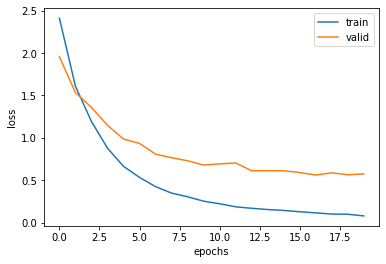

In [15]:
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="valid")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

### モデル保存

In [16]:
model_path = 'anime_classification_0730_epoch_20.pth'
torch.save(model.state_dict(), model_path)

### モデルロード

In [10]:
model_path = 'anime_classification_0730_epoch_20.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [17]:
# テストデータ処理
preds=[]
true=[]
path=[]
model.eval()
for i,batch_data in tqdm(enumerate(dataloaders["test"])):       
    batch_pred=model(batch_data["video"].to(device))
    _, predicted = torch.max(batch_pred, 1)
    path.extend(batch_data["paths"])
    true.extend(batch_data["labels"].detach().to("cpu").tolist())
    preds.extend(predicted.detach().to("cpu").tolist())

22it [02:43,  7.43s/it]


In [19]:
print(accuracy_score(true, preds))
print(classification_report(true, preds))

0.8591954022988506
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.27      0.43        11
           2       1.00      0.71      0.83         7
           3       0.75      1.00      0.86         6
           4       0.89      0.80      0.84        20
           5       0.75      1.00      0.86         3
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       0.67      0.43      0.52        28
          11       1.00      0.80      0.89        10
          12       0.81      1.00      0.89        21
          13       0.86      0.92      0.89        13
          14       1.00      0.70      0.82        10
          15       0.92      0.81      0.86        27
          16       1.00      0.69      0.81        16
        

E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Rec

In [21]:
category_id2title=dict()
for i,j in category.items():
    category_id2title[j]=i

<AxesSubplot:>

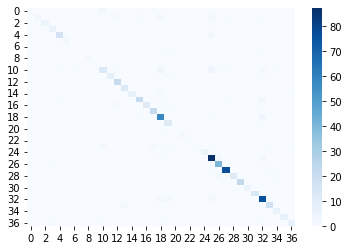

In [23]:
cm = confusion_matrix(true, preds)
sns.heatmap(cm,square=False, cbar=True, annot=False, cmap='Blues')